In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

In [2]:
def label_campaign(date: pd.Timestamp):
    if date < pd.Timestamp("2022-04-07") and date >= pd.Timestamp("2022-02-24"):
        return "Initial Invasion"
    elif date < pd.Timestamp("2022-08-28"):
        return "Souteastern Front"
    elif date < pd.Timestamp("2022-11-11"):
        return "Counteroffensive"
    elif date < pd.Timestamp("2023-03-28"):
        return "First Stalemate"
    elif date <= pd.Timestamp("2023-10-08"):
        return "Second Stalemate"
    else:
        return pd.NA

In [3]:
df_russia_losses = pd.read_csv("./russia_losses_personnel.csv", index_col=0, parse_dates=[0])
df_russia_losses["campaign"] = df_russia_losses.index.map(label_campaign)
df_aid = pd.read_csv("./ua_aid_revised.csv", parse_dates=[0], index_col=0)
df_all = df_russia_losses.merge(df_aid, left_index=True, right_index=True, how="left").fillna(0)

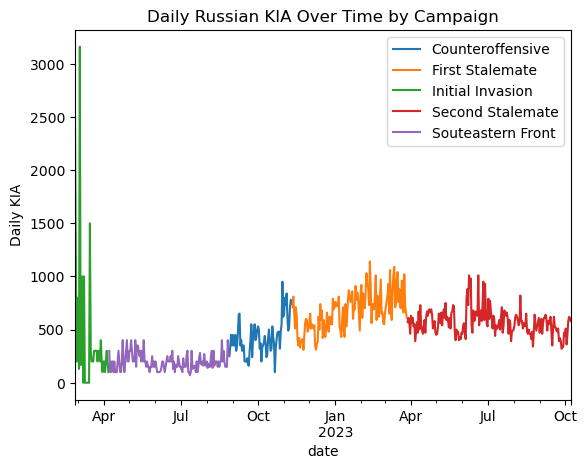

In [4]:
df_all.groupby("campaign")["daily_total"].plot(
    ylabel="Daily KIA",
    title="Daily Russian KIA Over Time by Campaign"
)
plt.legend()

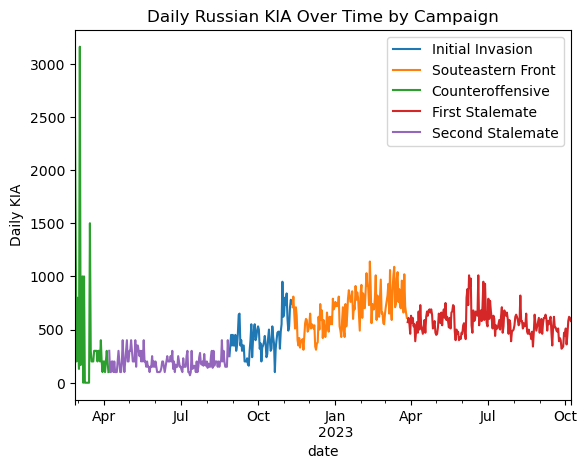

In [5]:
def label_campaign(date: pd.Timestamp):
    if date < pd.Timestamp("2022-04-07") and date >= pd.Timestamp("2022-02-24"):
        return "Initial Invasion"
    elif date < pd.Timestamp("2022-08-28"):
        return "Souteastern Front"
    elif date < pd.Timestamp("2022-11-11"):
        return "Counteroffensive"
    elif date < pd.Timestamp("2023-03-28"):
        return "First Stalemate"
    elif date <= pd.Timestamp("2023-10-08"):
        return "Second Stalemate"
    else:
        return pd.NA

df_russia_losses = pd.read_csv("./russia_losses_personnel.csv", index_col=0, parse_dates=[0])
df_russia_losses["campaign"] = df_russia_losses.index.map(label_campaign)
df_aid = pd.read_csv("./ua_aid_revised.csv", parse_dates=[0], index_col=0)
df_all = df_russia_losses.merge(df_aid, left_index=True, right_index=True, how="left").fillna(0)

# Get unique campaign values and sort them by their corresponding start dates
unique_campaigns = df_all.groupby("campaign").apply(lambda group: group.index.min()).sort_values().index

df_all.groupby("campaign")["daily_total"].plot(
    ylabel="Daily KIA",
    title="Daily Russian KIA Over Time by Campaign"
)
plt.legend(unique_campaigns)

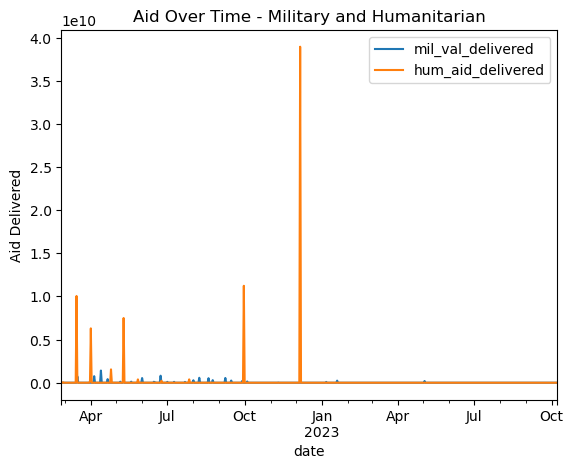

In [6]:
df_all[["mil_val_delivered", "hum_aid_delivered"]].plot(
    ylabel="Aid Delivered",
    title="Aid Over Time - Military and Humanitarian"
)
plt.legend()

In [7]:
df_aid_kia = (
    df_all[["total", "daily_total"]]
    .rename(columns={"total": "total_aid", "daily_total": "total_kia"})
    .fillna(0)
)

Text(0, 0.5, 'Total KIA')

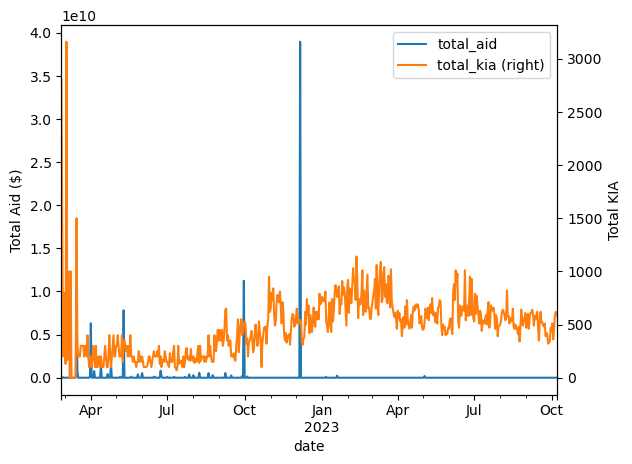

In [8]:
ax = df_aid_kia[["total_aid", "total_kia"]].plot(
    label="Aid recieved (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Total Aid ($)")
plt.ylabel("Total KIA")

In [9]:
# get rid of the initial days, since these are likely distributed quite different from the sustained war
april2022_onwards = df_aid_kia.index > pd.Timestamp("2022-04-01")

df_aid_kia = df_aid_kia[april2022_onwards]

Text(0, 0.5, 'Total KIA')

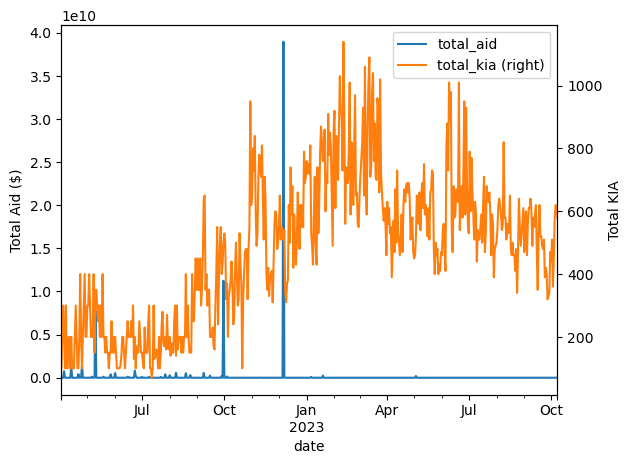

In [10]:
ax = df_aid_kia[["total_aid", "total_kia"]].plot(
    label="Aid recieved (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Total Aid ($)")
plt.ylabel("Total KIA")

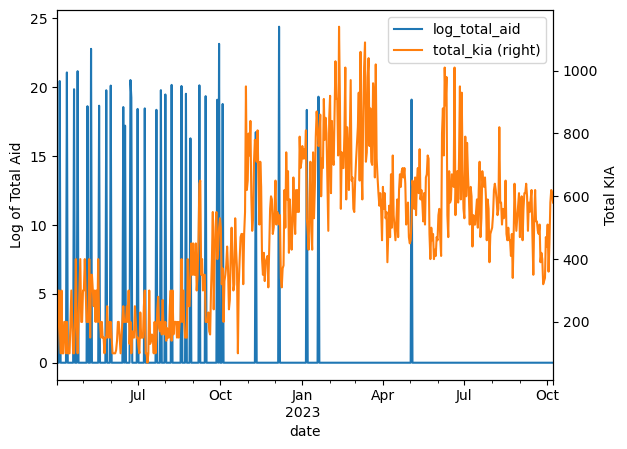

In [11]:
# It's big, it's heavy, it's wood, it's better than bad, it's good
df_aid_kia["log_total_aid"] = np.log1p(df_aid_kia["total_aid"])

# Plot using the log transformation of total_aid
ax = df_aid_kia[["log_total_aid", "total_kia"]].plot(
    label="Log of Aid received (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Log of Total Aid")
plt.ylabel("Total KIA")
plt.show()

In [12]:
def plot_and_fit(df_aid_kia: pd.DataFrame, aid_shift: int=0, freq: str="3W"):
    # Make a copy of the input dataframe, so that we don't change the original one below.
    df_aid_kia_copy = df_aid_kia[["total_aid", "total_kia"]].copy()

    # check that the time axis has a value for every day, or else the `shift` won't work
    # (there's probably a simpler way to code this)
    nanoseconds_in_one_day = 24*60*60*1e9
    assert np.all(df_aid_kia.index.to_series().diff().dropna().unique() == pd.to_timedelta(nanoseconds_in_one_day))

    # If requested, shift the aid data by `aid_shift`. If there is always 1 point per day
    # you will shift by `aid_shift` days.
    # When we do the regression, we will then be fitting on whether there is a lag of
    # `aid_shift` between when aid arrives and when KIA raet goes up.
    if aid_shift:
        df_aid_kia_copy["total_aid"] = df_aid_kia_copy["total_aid"].shift(aid_shift)
        df_aid_kia_copy = df_aid_kia_copy.dropna()


    # Get the cululative aid over time (rather than aid on any given day)
    # Then group by some amount of time (in this function in panads, "3W" is 3 weeks,
    # "1M" would be 1 month, etc).
    # NB: the last data point in the series might not be a full time window, so it might
    # have lower sums.
    # NB 2: we need to have the cumsum after the grouping step to count correctly.
    aid = (
        df_aid_kia_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group KIAs by the same grouping of time.
    kia = (
        df_aid_kia_copy["total_kia"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    kia.plot(ax=ax, secondary_y=True)
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('KIA per day')
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid
    y = kia
    model2 = LinearRegression()
    model2.fit(X.values.reshape(-1, 1), y.values)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model2.coef_*X_fit + model2.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('KIA per day')

    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient: {model2.coef_[0]}")
    print(f"intercept: {model2.intercept_}")
    
    # Note that the Statsmodels approach gives the same result and is
    # a little more R-like
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    print(res.summary())

In [13]:
# Print the structure of the DataFrame
print(df_aid_kia.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 555 entries, 2022-04-02 to 2023-10-08
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_aid      555 non-null    float64
 1   total_kia      555 non-null    int64  
 2   log_total_aid  555 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 17.3 KB
None


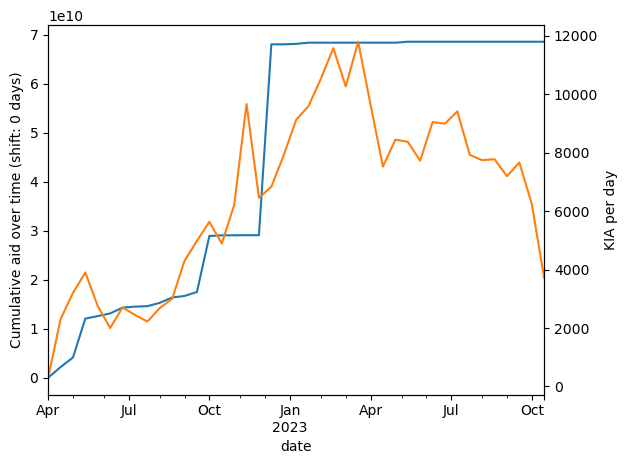

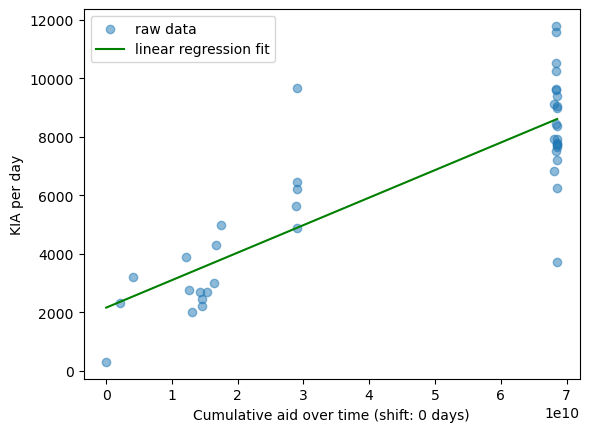

coefficient: 9.407742622322782e-08
intercept: 2156.6568849822843


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:              total_kia   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     90.33
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.06e-11
Time:                        15:20:29   Log-Likelihood:                -361.51
No. Observations:                  41   AIC:                             727.0
Df Residuals:                      39   BIC:                             730.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [14]:
plot_and_fit(df_aid_kia, aid_shift=0, freq="2W")

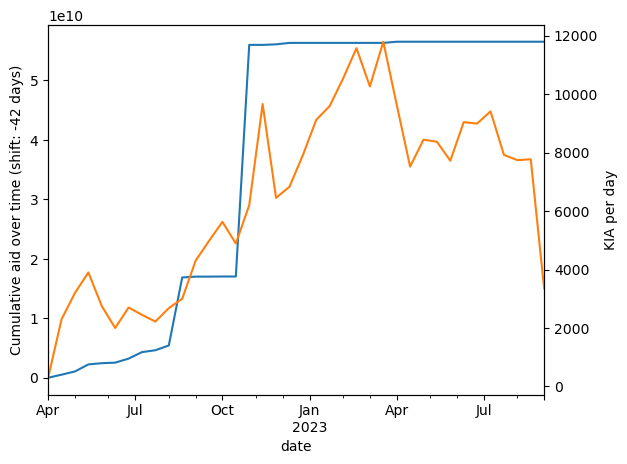

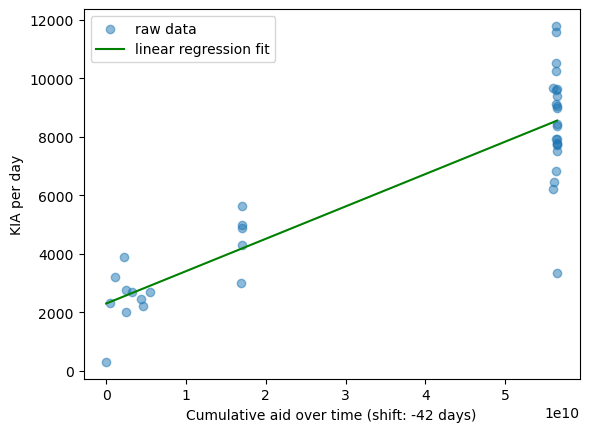

coefficient: 1.1071046716158551e-07
intercept: 2296.612200409756


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:              total_kia   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     113.6
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.10e-12
Time:                        15:20:36   Log-Likelihood:                -332.21
No. Observations:                  38   AIC:                             668.4
Df Residuals:                      36   BIC:                             671.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [15]:
plot_and_fit(df_aid_kia, aid_shift=-42, freq="2W")

In [16]:
import pandas as pd

# Read the CSV file into a DataFrame
file_path = "/Users/test/Desktop/Capstone/ua_civ_cas_aid.csv"
df_new = pd.read_csv(file_path, parse_dates=[0], index_col=0)

# Print the structure of the DataFrame
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, Feb-22 to Jul-23
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   civ_kill         18 non-null     int64
 1   total_aid_month  18 non-null     int64
dtypes: int64(2)
memory usage: 432.0+ bytes
None


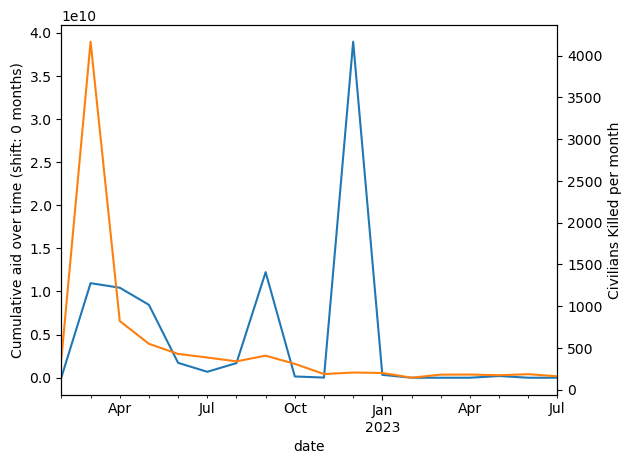

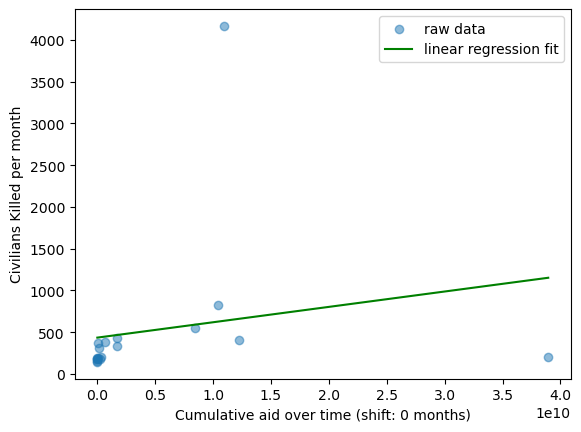

Coefficient: 1.8404310583322494e-08
Intercept: 435.0739834619572

Statsmodels summary:

                            OLS Regression Results                            
Dep. Variable:               civ_kill   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.6033
Date:                Thu, 14 Dec 2023   Prob (F-statistic):              0.449
Time:                        15:20:55   Log-Likelihood:                -147.65
No. Observations:                  18   AIC:                             299.3
Df Residuals:                      16   BIC:                             301.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/Users/test/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
def plot_and_fit(df_new: pd.DataFrame, aid_shift: int = 0, freq: str = "3W"):
    # Make a copy of the input DataFrame, so that we don't change the original one below.
    df_new_copy = df_new.copy()

    # Convert the index to a datetime-like format
    df_new_copy.index = pd.to_datetime(df_new_copy.index, format="%b-%y")

    # If requested, shift the aid data by `aid_shift`.
    if aid_shift:
        df_new_copy["total_aid_month"] = df_new_copy["total_aid_month"].shift(aid_shift)
        df_new_copy = df_new_copy.dropna()

    # Plot the cumulative aid over time and Civilians Killed per month.
    ax = df_new_copy["total_aid_month"].plot()
    df_new_copy["civ_kill"].plot(ax=ax, secondary_y=True)
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} months)")
    ax.right_ax.set_ylabel('Civilians Killed per month')
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = df_new_copy["total_aid_month"]
    y = df_new_copy["civ_kill"]
    model = LinearRegression()
    model.fit(X.values.reshape(-1, 1), y.values)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model.coef_ * X_fit + model.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} months)")
    plt.ylabel('Civilians Killed per month')

    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")

    # Use Statsmodels to provide additional statistics on the regression.
    X_sm = sm.add_constant(X)
    mod = sm.OLS(y, X_sm)
    res = mod.fit()
    print("\nStatsmodels summary:\n")
    print(res.summary())

# Assuming df_new is the DataFrame you want to use for the regression
plot_and_fit(df_new, aid_shift=0, freq="3W")


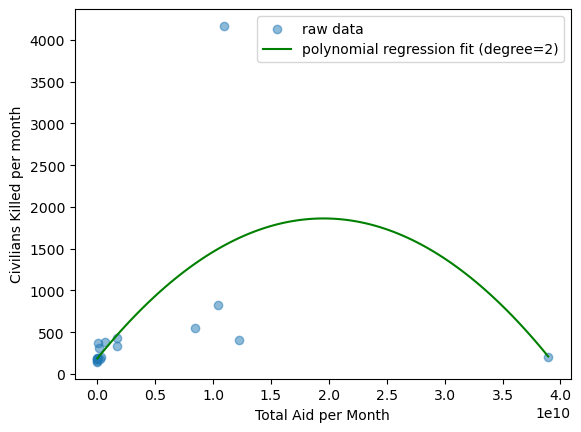

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Bendy Boi
# Assuming df_new is the DataFrame you want to use for the regression
X = df_new["total_aid_month"].values.reshape(-1, 1)
y = df_new["civ_kill"].values

# Set the degree of the polynomial
degree = 2

# Create a pipeline with PolynomialFeatures and LinearRegression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
model.fit(X, y)

# Plot the raw data along with the polynomial regression fit
plt.scatter(X, y, alpha=0.5, label="raw data")
X_fit = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
y_fit = model.predict(X_fit)

plt.xlabel("Total Aid per Month")
plt.ylabel('Civilians Killed per month')

plt.plot(X_fit, y_fit, color="g", label=f"polynomial regression fit (degree={degree})")
plt.legend()
plt.show()


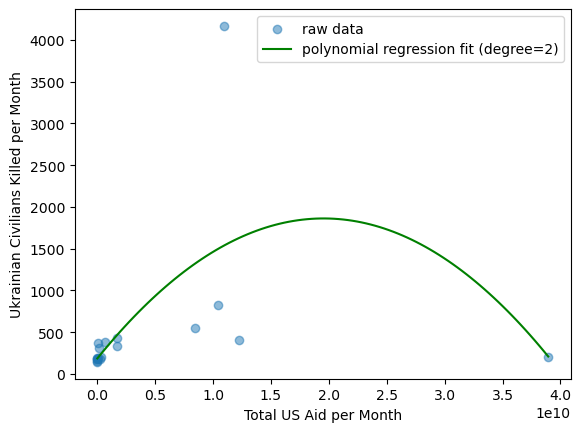

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     7.480
Date:                Thu, 14 Dec 2023   Prob (F-statistic):             0.0147
Time:                        15:09:15   Log-Likelihood:                -144.53
No. Observations:                  18   AIC:                             293.1
Df Residuals:                      16   BIC:                             294.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.702e-17   7.04e-18      3.836      0.0

/Users/test/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [19]:
import statsmodels.api as sm

# Fit the sklearn Polynomial Regression model
model.fit(X, y)

# Get the polynomial features
X_poly = PolynomialFeatures(degree).fit_transform(X)

# Fit the Statsmodels OLS model
mod = sm.OLS(y, sm.add_constant(X_poly))
res = mod.fit()

# Plot the raw data along with the polynomial regression fit
plt.scatter(X, y, alpha=0.5, label="raw data")
plt.xlabel("Total US Aid per Month")
plt.ylabel('Ukrainian Civilians Killed per Month')

plt.plot(X_fit, model.predict(X_fit), color="g", label=f"polynomial regression fit (degree={degree})")
plt.legend()
plt.show()

# Display the regression results
print(res.summary())

In [ ]:
##### NO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Assuming df_new is the DataFrame you want to use for the regression
# Make sure to replace 'df_new' with your actual DataFrame

#df_new_copy = df_new.copy()

# Extracting the independent variable (X) and dependent variable (y)
#X = df_new_copy['total_aid_month'].values.reshape(-1, 1)
#y = df_new_copy['civ_kill'].values

# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the SVR model
#svr = SVR(kernel='linear')
#svr.fit(X_train, y_train)

# Predicting the values on the test set
#y_pred = svr.predict(X_test)

# Plotting the results
#plt.scatter(X_test, y_test, color='black', label='Actual')
#plt.plot(X_test, y_pred, color='blue', linewidth=3, label='SVR Prediction')
#plt.xlabel('Total Aid (per month)')
#plt.ylabel('Civilian Kill')
#plt.title('Support Vector Regression (SVR)')
#plt.legend()
#plt.show()

# Calculating and printing the Mean Squared Error (MSE)
#mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")

# Using Statsmodels to display additional regression statistics
#X_train_sm = sm.add_constant(X_train)
#model = sm.OLS(y_train, X_train_sm).fit()
#print(model.summary())


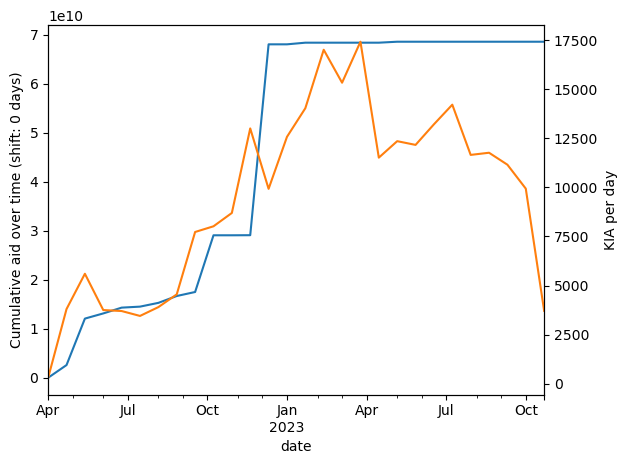

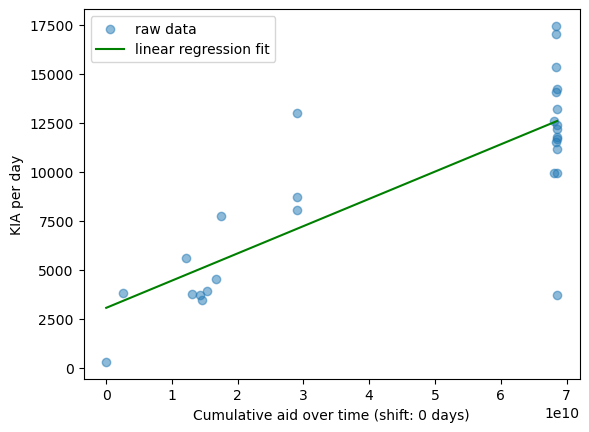

coefficient: 1.3893251216754332e-07
intercept: 3057.152431026522


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &    total\_kia    & \textbf{  R-squared:         } &     0.641   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.627   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     46.37   \\
\textbf{Date:}             & Thu, 14 Dec 2023 & \textbf{  Prob (F-statistic):} &  3.15e-07   \\
\textbf{Time:}             &     15:23:31     & \textbf{  Log-Likelihood:    } &   -261.61   \\
\textbf{No. Observations:} &          28      & \textbf{  AIC:               } &     527.2   \\
\textbf{Df Residuals:}     &          26      & \textbf{  BIC:               } &     529.9   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonro

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def plot_and_fit(df_aid_kia: pd.DataFrame, aid_shift: int=0, freq: str="3W"):
    # Make a copy of the input dataframe, so that we don't change the original one below.
    df_aid_kia_copy = df_aid_kia[["total_aid", "total_kia"]].copy()

    # check that the time axis has a value for every day, or else the `shift` won't work
    # (there's probably a simpler way to code this)
    nanoseconds_in_one_day = 24*60*60*1e9
    assert np.all(df_aid_kia.index.to_series().diff().dropna().unique() == pd.to_timedelta(nanoseconds_in_one_day))

    # If requested, shift the aid data by `aid_shift`. If there is always 1 point per day
    # you will shift by `aid_shift` days.
    # When we do the regression, we will then be fitting on whether there is a lag of
    # `aid_shift` between when aid arrives and when KIA rate goes up.
    if aid_shift:
        df_aid_kia_copy["total_aid"] = df_aid_kia_copy["total_aid"].shift(aid_shift)
        df_aid_kia_copy = df_aid_kia_copy.dropna()

    # Get the cumulative aid over time (rather than aid on any given day)
    # Then group by some amount of time (in this function in pandas, "3W" is 3 weeks,
    # "1M" would be 1 month, etc).
    # NB: the last data point in the series might not be a full time window, so it might
    # have lower sums.
    # NB 2: we need to have the cumsum after the grouping step to count correctly.
    aid = (
        df_aid_kia_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group KIAs by the same grouping of time.
    kia = (
        df_aid_kia_copy["total_kia"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    kia.plot(ax=ax, secondary_y=True)
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('KIA per day')
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid
    y = kia
    model2 = LinearRegression()
    model2.fit(X.values.reshape(-1, 1), y.values)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model2.coef_*X_fit + model2.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('KIA per day')

    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient: {model2.coef_[0]}")
    print(f"intercept: {model2.intercept_}")
    
    # Using statsmodels for detailed regression results in LaTeX format
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    print(res.summary().as_latex())

# Example usage
# Assuming df_aid_kia is your DataFrame
plot_and_fit(df_aid_kia, aid_shift=0, freq="3W")


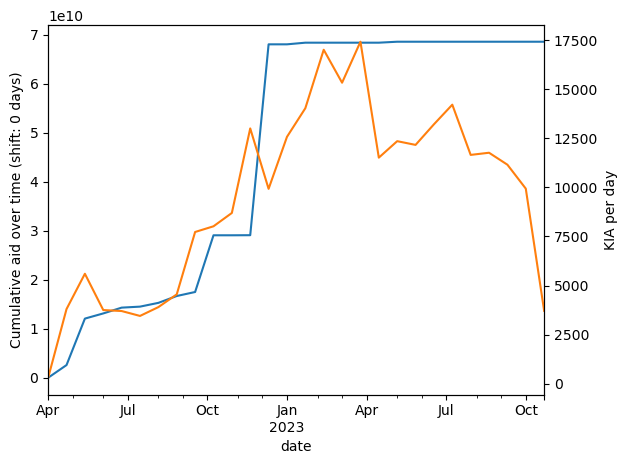

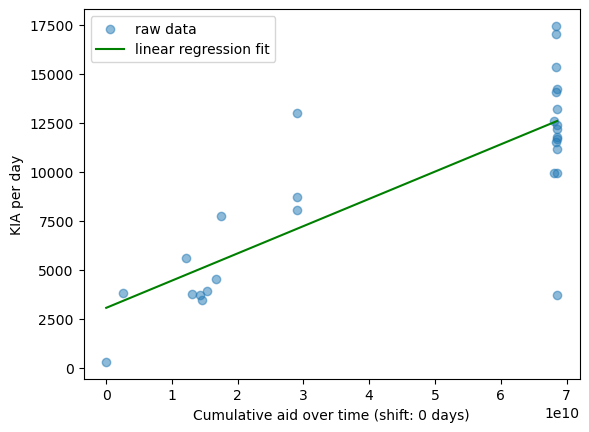

coefficient: 1.3893251216754332e-07
intercept: 3057.152431026522


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)



TypeError: as_latex() got an unexpected keyword argument 'caption'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def plot_and_fit(df_aid_kia: pd.DataFrame, aid_shift: int=0, freq: str="3W"):
    # Make a copy of the input dataframe, so that we don't change the original one below.
    df_aid_kia_copy = df_aid_kia[["total_aid", "total_kia"]].copy()

    # check that the time axis has a value for every day, or else the `shift` won't work
    # (there's probably a simpler way to code this)
    nanoseconds_in_one_day = 24*60*60*1e9
    assert np.all(df_aid_kia.index.to_series().diff().dropna().unique() == pd.to_timedelta(nanoseconds_in_one_day))

    # If requested, shift the aid data by `aid_shift`. If there is always 1 point per day
    # you will shift by `aid_shift` days.
    # When we do the regression, we will then be fitting on whether there is a lag of
    # `aid_shift` between when aid arrives and when KIA rate goes up.
    if aid_shift:
        df_aid_kia_copy["total_aid"] = df_aid_kia_copy["total_aid"].shift(aid_shift)
        df_aid_kia_copy = df_aid_kia_copy.dropna()

    # Get the cumulative aid over time (rather than aid on any given day)
    # Then group by some amount of time (in this function in pandas, "3W" is 3 weeks,
    # "1M" would be 1 month, etc).
    # NB: the last data point in the series might not be a full time window, so it might
    # have lower sums.
    # NB 2: we need to have the cumsum after the grouping step to count correctly.
    aid = (
        df_aid_kia_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group KIAs by the same grouping of time.
    kia = (
        df_aid_kia_copy["total_kia"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    kia.plot(ax=ax, secondary_y=True)
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('KIA per day')
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid
    y = kia
    model2 = LinearRegression()
    model2.fit(X.values.reshape(-1, 1), y.values)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model2.coef_*X_fit + model2.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('KIA per day')

    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient: {model2.coef_[0]}")
    print(f"intercept: {model2.intercept_}")
    
    # Using statsmodels for detailed regression results in LaTeX format with customized styling
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    
    # Convert the dfoutput to LaTeX format with customization
    latex_table = res.summary().as_latex(
        caption="OLS Regression Results",
        label="tab:ols_results",
        bold_rows=True,
        use_pandas=False,
    )
    
    print(latex_table)

# Example usage
# Assuming df_aid_kia is your DataFrame
plot_and_fit(df_aid_kia, aid_shift=0, freq="3W")



